<a href="https://colab.research.google.com/github/JonMcEntee/hm-fashion-recommendations/blob/main/H%26M_Fashion_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install implicit

In [2]:
from datetime import datetime, timedelta
from collections import defaultdict
from functools import partial
from implicit.als import AlternatingLeastSquares

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import implicit
import random

random_seed = 42

In [3]:
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# H&M Fashion Recommendations

This notebook details my approach to Kaggle's [H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview) competition, focused on predicting customers' next fashion purchases. With vast product selections becoming standard in retail, delivering precisely tailored suggestions is key to enhancing shopping experiences and brand loyalty in modern fashion commerce.

# Summary (TL;DR)
This notebook explores methods for building a personalized product recommendation system on transaction data from the H&M fashion retail dataset. Below is a summary of the workflow and findings:

 - **Goal**: Predict which fashion items a customer is most likely to purchase next, based on historical transaction data.
 - **Dataset Used**:
  - H&M Kaggle competition dataset:
    - `transactions_train.csv`: Customer purchase history with timestamps
    - `articles.csv`: Metadata for fashion products
    - `customers.csv`: Demographic and behavioral customer data
 - **Baseline Approach**: Filter and return items based on global popularity
 - **ALS Model (Collaborative Filtering)**
  - Implemented using the `implicit` library's Alternating Least Squares (ALS) algorithm
  - Trains latent embeddings for customers and articles by factorizing the interaction matrix
 - **Ranking and Recommendation Strategy**
  - System generates a top-N list of recommendations per customer
  - Recommendations are ranked by predicted relevance scores from the model
 - **Results**
  - ALS provided personalized product suggestions aligned with recent customer behavior

# Evaluation Metrics

To evaluate our recommendations, we use Mean Average Precision at 12 (MAP@12), which is aligned with the competition's evaluation metric. It captures both the relevance and ranking of recommended items.

$$\text{MAP}@12 = \frac{1}{U} \sum_{u=1}^{U} \frac{1}{\min(m, 12)} \sum_{k=1}^{12} P(k) \cdot \text{rel}(k)$$

In [40]:
def mapk(recommender, test, k=12):
    """
    Computes Mean Average Precision at K (MAP@K) for a recommendation system.

    Parameters:
    ----------
    recommender : function
        A function that takes a list of customer IDs and returns a DataFrame
        with columns ['customer_id', 'rank', 'recommendation'] where rank
        ranges from 1 to K.

    test : pd.DataFrame
        A DataFrame containing actual purchases with at least two columns:
        'customer_id' and 'article_id'.

    k : int, default=12
        The number of top recommendations to consider for each customer.

    Returns:
    -------
    float
        The MAP@K score.
    """

    # Extract unique customers from the test set
    customers = test['customer_id'].unique()

    # Build dictionary of actual purchased items per customer
    actuals = (
        test[test['customer_id'].isin(customers)][['customer_id', 'article_id']]
        .groupby('customer_id')['article_id']
        .apply(set)
        .to_dict()
    )

    # Get recommendations from the model
    predictions = recommender(customers)

    # Pivot to create a customer x rank matrix of recommended items
    pred_matrix = (
        predictions.pivot(index='customer_id', columns='rank', values='recommendation')
        .reindex(customers)
        .values
    )

    # Build list of actual purchases in the same order as customer list
    actuals_list = [actuals.get(cust_id, set()) for cust_id in customers]

    # Create binary hit matrix: 1 if recommended item is in actual purchases
    hit_matrix = np.zeros_like(pred_matrix, dtype=np.float32)
    for i, row in enumerate(pred_matrix):
        hit_matrix[i] = [item in actuals_list[i] for item in row]

    # Compute cumulative hits and precision at each rank
    cumsum_hits = np.cumsum(hit_matrix, axis=1)
    inv_ranks = 1 / np.arange(1, k + 1)
    precisions = hit_matrix * (cumsum_hits * inv_ranks)

    # Avoid division by zero by ensuring actual length is at least 1
    actuals_length = np.fromiter(
        (len(a) if a else 1 for a in actuals_list), dtype=np.int32, count=len(actuals_list)
    )

    # Compute Average Precision per customer
    ap_per_customer = precisions.sum(axis=1) / np.minimum(k, actuals_length)

    # Return mean over all customers
    return float(np.mean(ap_per_customer))

# **Data Loading and Preprocessing**

In [5]:
directory = "./drive/My Drive/h-and-m-personalized-fashion-recommendations/"
articles = pd.read_csv(directory + "articles.csv")
customers = pd.read_csv(directory + "customers.csv")
transactions = pd.read_csv(directory + "transactions_train.csv",
                           parse_dates=['t_dat'])\
                 .sample(frac=0.01, random_state=random_seed)

In [6]:
# add week column
total_weeks = (transactions.t_dat.max() - transactions.t_dat.min()).days // 7 # 104
transactions['week'] = total_weeks - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

Before modeling, we divide the dataset into training and testing subsets. This allows us to simulate a real-world recommendation scenario where predictions are made on unseen data.

In [7]:
test_start = datetime(2020, 9, 16)
train = transactions[transactions.week < total_weeks].reset_index(drop=True)
test = transactions[transactions.week == total_weeks].reset_index(drop=True)

# add time decay column
train["time_decay"] = train["t_dat"].apply(lambda x : 1 / (test_start - x).days)

ground_truth = (
  test[["customer_id", "article_id"]]
  .drop_duplicates()
  .groupby('customer_id')['article_id']
  .apply(list)
  .reset_index()
)

ground_truth.columns = ["customer", "purchased"]

fitset = transactions[transactions.week < total_weeks - 1].reset_index(drop=True)
validation = transactions[transactions.week == total_weeks - 1].reset_index(drop=True)

validation_truth = (
  test[["customer_id", "article_id"]]
  .drop_duplicates()
  .groupby('customer_id')['article_id']
  .apply(list)
  .reset_index()
)

validation_truth.columns = ["customer", "purchased"]

**Key Data Files**  

1. **`articles.csv`**  
   - Contains detailed metadata for **105,542 unique fashion articles**, including:  
     - `article_id`: Unique identifier for each product.  
     - `product_code`, `prod_name`: Product identifiers and descriptions.  
     - `product_type_no`, `product_type_name`: Numerical and textual product categories.  
     - `product_group_name`: Broad category (e.g., "Garment Upper body").  
     - Visual attributes: `colour_group_name`, `perceived_colour_value_name`, `perceived_colour_master_name`

2. **`customers.csv`**  
   - Profiles **1,371,980 unique customers** with:  
     - `customer_id`: Unique identifier.  
     - `FN` (binary): Indicates if the customer subscribed to H&M’s fashion news.  
     - `Active` (binary): Customer activity status.  
     - `club_member_status`: Loyalty program status.  
     - `fashion_news_frequency`: Categorical. Level of engagement with H&M’s newsletters.  
     - `age`: Customer age.
     - `postal_code`: Location data.

3. **`transactions_train.csv`**  
   - Records **31,788,324 historical transactions** (Sept 2018–Sept 2020) with:  
     - `t_dat`: Transaction date.  
     - `customer_id`: Links to `customers.csv`.  
     - `article_id`: Links to `articles.csv`.  
     - `price`: Purchase price.
     - `sales_channel_id`: Online (1) vs. in-store (2) purchases.  
4. **`images/*.jpg`**
     - **105,104** jpeg images
      - images of each product (potential for computer vision analysis)


# Exploratory Data Analysis

To understand purchasing trends, I merged transaction data with article details (product type and group) and analyzed the distribution of sales across different product categories.  

In [ ]:
article_details = pd.merge(transactions,
                           articles[["article_id",
                                     "product_type_name",
                                     "product_group_name"]],
                           how="left", on="article_id")

product_types = article_details.groupby("product_type_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

product_groups = article_details.groupby("product_group_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

del article_details

The bar plot below highlights the top 40 product types by sales volume. Trousers dominate, followed by other upper-body garments like T-shirts and sweaters. This insight can guide inventory prioritization and recommendation strategies.

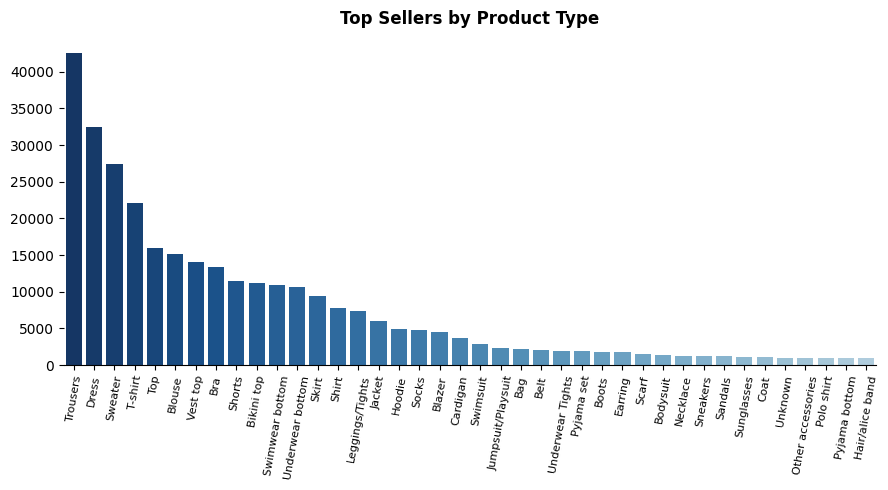

In [ ]:
plt.figure(figsize=(9, 5))
num_categories=40
custom_palette = sns.color_palette('Blues', num_categories + 20)[20:][::-1]
g = sns.barplot(
    product_types.head(num_categories),
    x = "product_type_name",
    y = "count",
    hue="product_type_name",
    palette=custom_palette,
    dodge=False)

g.tick_params(axis='x', labelrotation=80, labelsize=8)

g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Type", fontweight='bold', pad=10)
sns.despine(left=True)
plt.tight_layout()

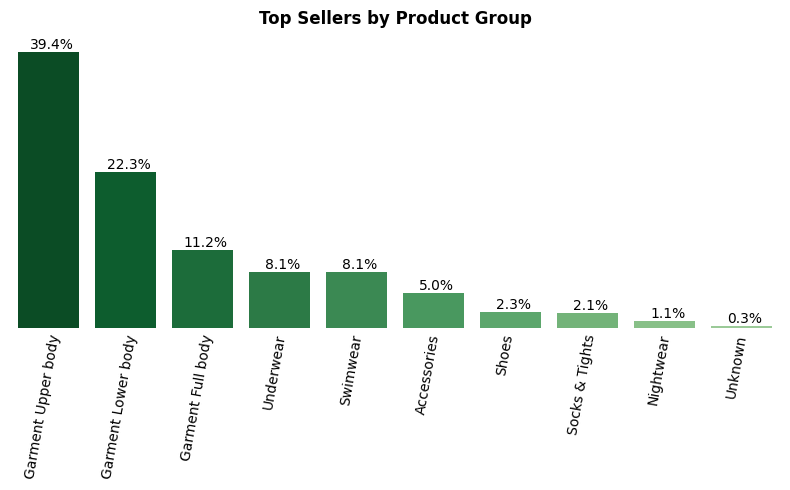

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=10
custom_palette = sns.color_palette('Greens', num_categories + 6)[6:][::-1]
g = sns.barplot(product_groups.head(num_categories), x = "product_group_name", y = "count", hue="product_group_name", palette=custom_palette)

total = product_groups['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=10)

g.tick_params(axis='x', labelrotation=80, labelsize=10, size=0);
shift_amount = -0.07
new_xticks = [x + shift_amount for x in g.get_xticks()]
g.set_xticks(new_xticks)

g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Group", fontweight='bold', pad=10)
g.axes.yaxis.set_visible(False)
sns.despine(left=True, bottom=True)
plt.tight_layout()

Purchase volume over time appears relatively stable, showing no clear upward or downward trend.

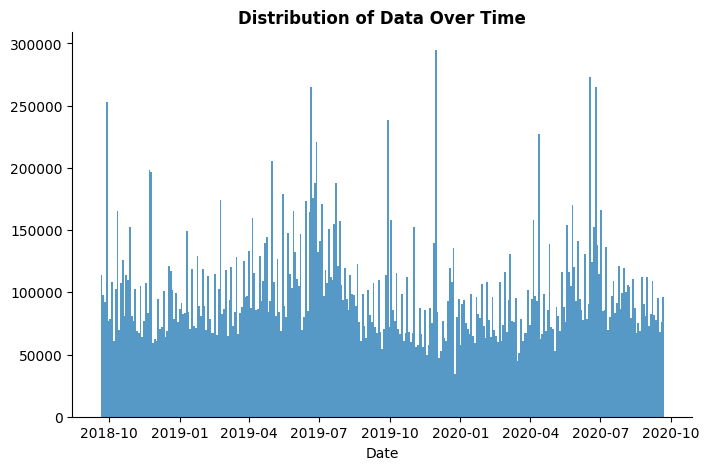

In [ ]:
plt.figure(figsize=(8, 5))
g = sns.histplot(transactions,
                 x = "t_dat",
                 edgecolor=None,
                 bins=100)

g.set_ylabel('', labelpad=0)
g.set_xlabel("Date")
g.set_title("Distribution of Data Over Time", fontweight="bold");
# g.tick_params(axis='x', labelrotation=80, labelsize=10);

sns.despine()

The majority of customers in the dataset have made at least one purchase, enabling the development of personalized recommendation models based on past behavior. However, for customers with limited or no transaction history, cold-start strategies (e.g., demographic-based or popularity-based recommendations) will be essential to provide meaningful suggestions.

In [ ]:
transaction_count = transactions\
  .groupby("customer_id")\
  .size()\
  .reset_index(name="count")\
  .groupby("count")\
  .size()\
  .reset_index(name="customers")

no_transactions = customers[
    ~customers["customer_id"].isin(transactions["customer_id"])]

transaction_count = pd.concat([
      pd.DataFrame([{
          "count": 0,
          "customers": len(no_transactions)
      }]),
      transaction_count
    ],
    ignore_index=True
)

bins = [0, 1, 2, 3, 5, 10, 50, 100, 200, np.inf]
labels = ['0', '1', '2', '3-4', '5-9', '10-49', '50-99', '100-199', '200+']

transaction_count['count_bin'] = pd.cut(transaction_count['count'],
                                        bins=bins,
                                        labels=labels,
                                        right=False,
                                        include_lowest=True)

transaction_bins = transaction_count.groupby('count_bin', observed=True)['customers'].sum().reset_index()

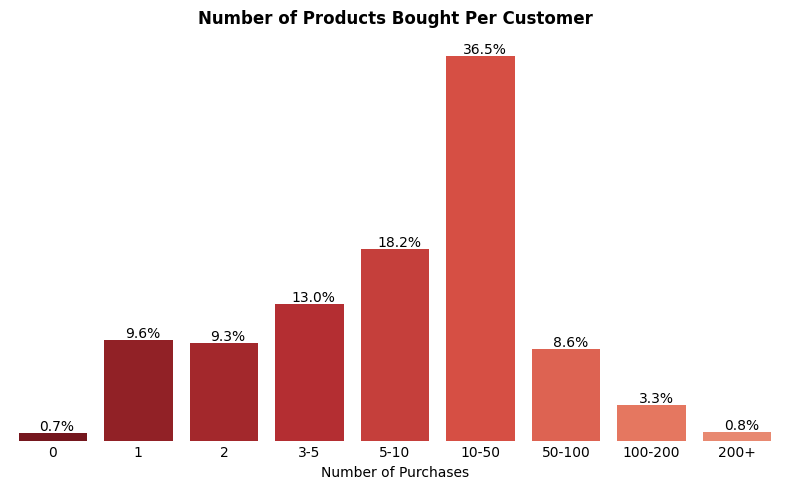

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=len(transaction_bins)
custom_palette = sns.color_palette('Reds', num_categories + 6)[6:][::-1]
g = sns.barplot(transaction_bins,
                x = "count_bin",
                y = "customers",
                hue="count_bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = transaction_bins['customers'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.05,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=10)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Number of Purchases")
g.set_ylabel("Number of Customers")
g.set_title("Number of Products Bought Per Customer", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

 Analysis of the customer age distribution indicates a clear skew toward younger demographics. This trend may reflect H&M’s brand positioning and marketing efforts and should be considered when tailoring recommendation strategies to align with customer preferences.

In [ ]:
age_count = customers.groupby("age").size().reset_index(name="count")

bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, np.inf]
labels = ['16-19', '20-24', '25-29', '30-34', '34-39', '40-44', '45-49',
          '50-54', '55-59', '60-64', '65-69', '70-74', '75+']

age_count["bin"] = pd.cut(age_count["age"],
                          bins=bins,
                          labels=labels,
                          right=False,
                          include_lowest=True)

age_bin = age_count.groupby('bin', observed=True)['count'].sum().reset_index()

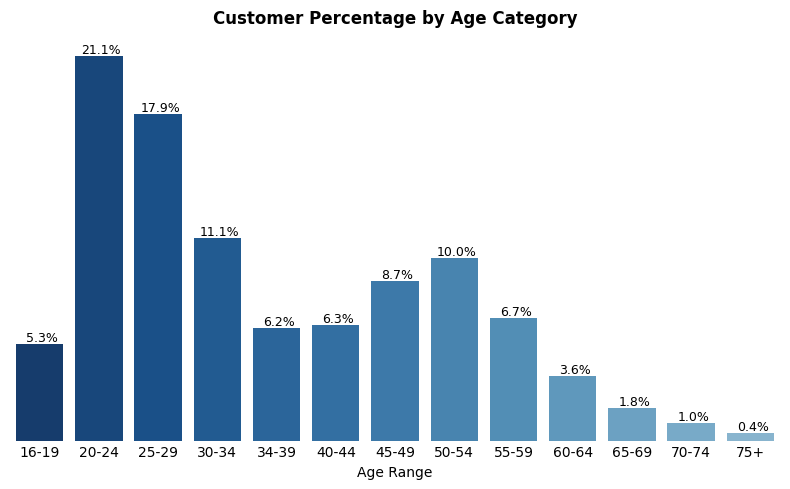

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=len(age_bin)
custom_palette = sns.color_palette('Blues', num_categories + 10)[10:][::-1]
g = sns.barplot(age_bin,
                x = "bin",
                y = "count",
                hue="bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = age_bin['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=9)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Age Range")
g.set_ylabel("Number of Purchases")
g.set_title("Customer Percentage by Age Category", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

This age-related trend extends to purchasing behavior, where younger customers also account for a higher percentage of total transactions. Models may benefit from age-group segmentation to enhance prediction accuracy by capturing generational shopping patterns.

In [ ]:
customer_purchases = pd.merge(transactions,
                              customers,
                              how="left", on="customer_id")

bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, np.inf]
labels = ['16-19', '20-24', '25-29', '30-34', '34-39', '40-44', '45-49',
          '50-54', '55-59', '60-64', '65-69', '70-74', '75+']

customer_purchases["bin"] = pd.cut(customer_purchases["age"],
                                   bins=bins,
                                   labels=labels,
                                   right=False,
                                   include_lowest=True)

purchase_bin = customer_purchases.groupby('bin', observed=True).size().reset_index(name="count")

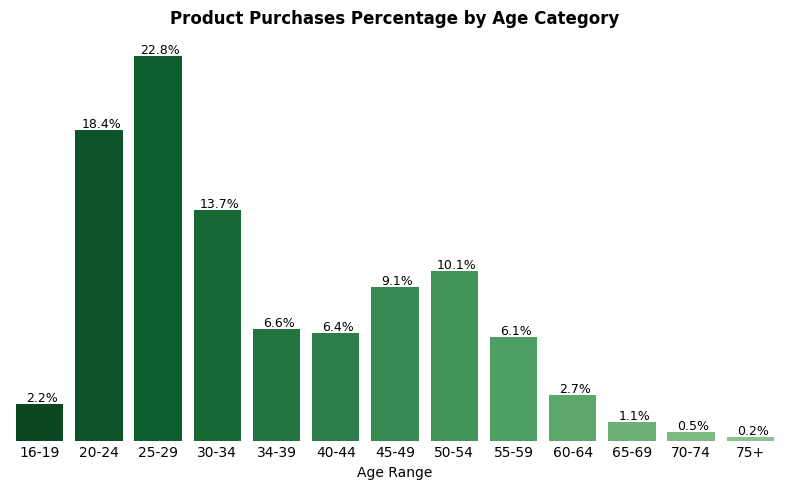

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=len(purchase_bin)
custom_palette = sns.color_palette('Greens', num_categories + 10)[10:][::-1]
g = sns.barplot(purchase_bin,
                x = "bin",
                y = "count",
                hue="bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = purchase_bin['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=9)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Age Range")
g.set_ylabel("Number of Purchases")
g.set_title("Product Purchases Percentage by Age Category", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Baseline Model: Most Popular Items

To establish a reference point for evaluating more advanced recommendation strategies, we start with a straightforward baseline model: recommending the most frequently purchased items. This simple heuristic serves as a sanity check and helps quantify the minimum performance a more sophisticated model should exceed.


Our baseline model recommends the top-k most frequently purchased articles across all users in the training set. This approach assumes that popularity alone is a good predictor of future purchases.

In [41]:
top = train\
  .groupby("article_id")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name="count")\
  .article_id\
  .tolist()

def baseline(customers, k=12):
  return pd.DataFrame({
      "customer_id" : [customer for customer in customers for _ in range(k)],
      "rank" : list(range(1, k+1)) * len(customers),
      "recommendation" : top[:k] * len(customers)
  })

Applying the most popular items recommender yields a MAP@12 score of approximately `0.0029`. While this performance is relatively low, it provides a meaningful reference point against which more advanced models (e.g., collaborative filtering) can be evaluated.

In [42]:
mapk(baseline, test)

0.0032676198729058347

While our initial baseline recommends globally popular items, it does not account for recency, which can be crucial in dynamic domains like fashion. To address this, we weight transactions by how recent they are, favoring items that were purchased more recently.

We introduce a time-decay factor to weight each transaction inversely by the number of days before the start of the test period:

In [43]:
top_temporal = train\
  .groupby("article_id")["time_decay"]\
  .sum()\
  .sort_values(ascending=False)\
  .reset_index(name="count")\
  .article_id\
  .tolist()

def temporal_baseline(customers, k=12):
  return pd.DataFrame({
      "customer_id" : [customer for customer in customers for _ in range(k)],
      "rank" : list(range(1, k+1)) * len(customers),
      "recommendation" : top_temporal[:k] * len(customers)
  })

The temporal baseline achieves a MAP@12 score of approximately `0.0055`, nearly doubling the score from our original baseline.

In [44]:
mapk(temporal_baseline, test)

0.007610863525074964

In [74]:
item_list = articles.article_id.unique()

def random_baseline(customers, k=12):
    customers = np.asarray(customers)
    n_customers = len(customers)

    if k > len(item_list):
        raise ValueError("k must be <= number of unique items")

    # Generate an array of shape (n_customers, len(item_list))
    item_list_array = np.asarray(item_list)

    # Create shuffled indices for each customer
    shuffled_indices = np.array([
        np.random.choice(len(item_list_array), size=k, replace=False)
        for _ in range(n_customers)
    ])

    # Gather items by index
    sampled_items = item_list_array[shuffled_indices]

    # Flatten for final DataFrame
    return pd.DataFrame({
        "customer_id": np.repeat(customers, k),
        "rank": np.tile(np.arange(1, k + 1), n_customers),
        "recommendation": sampled_items.flatten()
    })

In [75]:
mapk(random_baseline, test)

0.0

#Matrix Factorization with ALS

To move beyond popularity-based methods, we turn to Collaborative Filtering using Matrix Factorization via Alternating Least Squares (ALS). This technique models latent relationships between users and items based on historical interaction patterns.

To incorporate time dynamics into ALS, we define a confidence score for each interaction that decreases with the age of the transaction:

$$
c_{\text{user},\text{item}} = \alpha \cdot \sum_{i} \frac{1}{d_i}
$$

Where:
 - $d_i$ is the number of days since transaction $i$.
 - $\alpha$ is a tunable scaling factor.

We prepare the data by mapping customer and article IDs to integer indices, compute confidence scores using time decay, and construct a dense user-item matrix for training the ALS model.

In [ ]:
def train_als_model(train, factors, iterations, regularization, alpha):
  user_ids = train['customer_id'].unique()
  item_ids = train['article_id'].unique()

  user_map = {id_: idx for idx, id_ in enumerate(user_ids)}
  item_map = {id_: idx for idx, id_ in enumerate(item_ids)}

  train['user_idx'] = train['customer_id'].map(user_map)
  train['item_idx'] = train['article_id'].map(item_map)

  purchase_counts = train.groupby(['user_idx', 'item_idx'])["time_decay"].sum().reset_index(name='count')

  item_user_matrix = sp.coo_matrix(
      (purchase_counts['count'].astype(np.float32),
        (purchase_counts['user_idx'], purchase_counts['item_idx'])),
      shape=(len(user_map), len(item_map))
  ).tocsr()

  als_model = AlternatingLeastSquares(
      factors=factors,
      regularization=regularization,
      iterations=iterations,
      random_state=random_seed
  )

  als_model.fit(item_user_matrix)

  return als_model, item_user_matrix, user_map, item_map

One challenge with collaborative filtering is the cold start problem. ALS cannot recommend items for users with no historical data. To handle this, we fall back to our `temporal_baseline` model for unseen users.

In [ ]:
def als_recommender(customer, als_model, item_user_matrix, user_map, item_map, k=12):
    if customer not in user_map:
        return temporal_baseline(customer, k=k)

    reverse_item_map = {idx: id_ for id_, idx in item_map.items()}

    user_idx = user_map[customer]
    recommended = als_model.recommend(user_idx, item_user_matrix[user_idx], N=k, filter_already_liked_items=False)

    # Map internal item indices back to article_ids
    return [int(reverse_item_map[item_idx]) for item_idx in recommended[0]]

To optimize the performance of our ALS model, we conduct a grid search over several key hyperparameters. This systematic search allows us to evaluate different combinations of model settings and identify those that yield the best recommendation quality, measured using MAP@12.

In [ ]:
results = []
for regularization in [0.1]:
    for factors in [20, 30]:
        for iterations in [5, 10]:
            for alpha in [30, 50, 100, 150]:
                als_model, item_user_matrix, user_map, item_map = train_als_model(
                    fitset, factors, iterations, regularization, alpha
                )
                als_partial = partial(
                    als_recommender,
                    als_model=als_model,
                    item_user_matrix=item_user_matrix,
                    user_map=user_map,
                    item_map=item_map
                )
                result = {
                    "regularization": regularization,
                    "factors": factors,
                    "iterations": iterations,
                    "alpha": alpha,
                    "map12": mapk(als_partial, validation_truth)
                }
                results.append(result)
                print(result)

In [ ]:
 pd.DataFrame.from_records(results).sort_values("map12", ascending=False).head(5)

,regularization,factors,iterations,alpha,map12
1,0.1,20,5,50,0.004827
9,0.1,30,5,50,0.004610
2,0.1,20,5,100,0.004598
0,0.1,20,5,30,0.004581
10,0.1,30,5,100,0.004570


Based on the grid search, we retrain the ALS model on the full training dataset.

In [ ]:
als_model, item_user_matrix, user_map, item_map = train_als_model(
    train,
    factors=20,
    iterations=5,
    regularization=0.1,
    alpha=50
)

als_partial = partial(
    als_recommender,
    als_model=als_model,
    item_user_matrix=item_user_matrix,
    user_map=user_map,
    item_map=item_map
)

The tuned ALS model achieves a MAP@12 score of approximately `0.0069`, which outperforms both baseline recommenders.

In [ ]:
mapk(als_partial, ground_truth)

0.006031580349171337

# Candidate Generation with Simple Heuristics

To improve recommendation quality, we shift from relying solely on collaborative filtering models like ALS to a hybrid approach. The core idea is to first generate a manageable set of promising candidate items using simple heuristics, and then let a learning-to-rank model (such as LightGBM Ranker) determine the optimal order of these items per user. This two-stage recommendation pipeline balances speed, diversity, and personalization.

**Step 1: Heuristic-Based Candidate Generation
We generate a pool of article candidates per user using a mix of rules, including:**

1. **Most Popular Items** – Items with the highest sales across all customers.

2. **Time-Decayed Popularity** – Items that have sold well recently.

3. **Customer Purchase History** – Articles the user previously interacted with.

4. **Product Variants** – Other articles sharing the same `product_code` as items previously bought by the customer.

This allows us to propose items that are both broadly appealing and tailored to user preferences.

In [ ]:
# Precompute best sellers for all weeks upfront
best_sellers = train.groupby("week")["article_id"]\
  .value_counts()\
  .groupby("week")\
  .rank(method='dense', ascending=False)
best_sellers = best_sellers.rename('bestseller_rank').reset_index()
best_sellers['week'] += 1  # Shift for easy lookup of "last week"
best_sellers_dict = best_sellers.groupby('week')['article_id'].apply(list).to_dict()

To capture customer behavior, we store all articles each user has purchased by week:

In [ ]:
from collections import defaultdict

# Initialize dictionary
customer_history_pairs = defaultdict(list)

# Single pass through the data
for _, row in train.iterrows():
    customer_history_pairs[row['customer_id']].append(
        (row['week'], row['article_id'])
    )

Some products appear in multiple styles or variants. We identify these relations using `product_code`:


In [ ]:
# Precompute article to product_code mapping
article_to_product = {
    article : product for article, product in zip(articles.article_id, articles.product_code)
}

# Precompute product code mappings
product_code_map = articles.groupby('product_code')['article_id'].agg(list).to_dict()

The following function combines all of the above heuristics to build a personalized list of candidate articles per customer:

In [ ]:
def generate_recommendations(customer, week, k=12):
  recommendations = set()

  recommendations.update(baseline(customer, k=k))

  recommendations.update(temporal_baseline(customer, k=k))

  recommendations.update(best_sellers_dict.get(week, [])[:k])

  past_purchases = [ac for w, ac in \
                    customer_history_pairs[customer] if w <= week][:k]

  recommendations.update(past_purchases)

  for article in past_purchases:
    recommendations.update(product_code_map[article_to_product[article]])

  return list(recommendations)

Once candidates are generated, we train a model to learn ranking preferences by labeling known purchases as positive (`1`) and sampled non-purchases as negative (`0`).

In [ ]:
ranker_samples = train[["customer_id", "week"]].drop_duplicates()

ranker_samples["article_id"] = ranker_samples.apply(
    lambda x : generate_recommendations(
        x["customer_id"], x["week"], k=20),
    axis=1
    )

ranker_samples = ranker_samples.explode("article_id")
ranker_samples.head()

,customer_id,week,article_id
0,215895f90002eb3d1a04bd603513c8e85e6002ef08f136...,51,706016001
0,215895f90002eb3d1a04bd603513c8e85e6002ef08f136...,51,706016002
0,215895f90002eb3d1a04bd603513c8e85e6002ef08f136...,51,706016003
0,215895f90002eb3d1a04bd603513c8e85e6002ef08f136...,51,827968001
0,215895f90002eb3d1a04bd603513c8e85e6002ef08f136...,51,562245001


We label the items that the customer actually purchased as positives:

In [ ]:
positive_samples = train.merge(ranker_samples, on=["customer_id", "week", "article_id"])[["t_dat", "customer_id", "article_id", "week"]]
positive_samples["label"] = 1

All other candidates that were not purchased are negatives:

In [ ]:
positive_key = positive_samples[['customer_id', 'week', 'article_id']].drop_duplicates()
ranker_key = ranker_samples[['customer_id', 'week', 'article_id']].drop_duplicates()

# Find negative samples (in ranker but not in positive)
negative_samples = pd.merge(
    ranker_key,
    positive_key,
    on=['customer_id', 'week', 'article_id'],
    how='left',
    indicator=True
)

# Filter to only keep samples not in positive
negative_samples = negative_samples[negative_samples['_merge'] == 'left_only']

# Drop the merge indicator column
negative_samples = negative_samples.drop('_merge', axis=1)

# Add label column with 0 (negative)
negative_samples['label'] = 0

Finally, we concatenate a small subset of these negatives to avoid class imbalance:

In [ ]:
samples = pd.concat([positive_samples, negative_samples.sample(frac=0.2)]).drop("t_dat", axis=1)

# Feature Engineering

Now that we’ve generated a set of candidate articles and labeled them as positive (purchased) or negative (not purchased), the next step is to create meaningful features that the ranking model can learn from.

The goal of feature engineering in this context is to describe the relationship between a customer and a candidate article, using both demographic data, historical interactions, and item-level trends.

**Customer-Article Interaction Features:**
These features capture how aligned a candidate article is with a customer's historical preferences or profile.

**1. Distance from Average Age**: We compute how far the customer's age deviates from the average age of customers who typically purchase this article in the previous week.

In [ ]:
age_by_article = pd.merge(train, customers, on="customer_id")\
  .groupby(["week", "article_id"])["age"]\
  .mean()\
  .rename("average_age")\
  .reset_index()

average_age_by_article = {}
for _, row in age_by_article.iterrows():
  week, article_id, age = row
  average_age_by_article[(article_id, week)] = age

def distance_from_average_age(article_id, week, customer_age):
  # note, need to go for last week, hence week - 1
  if (article_id, week - 1) in average_age_by_article:
    return customer_age - average_age_by_article[(article_id, week - 1)]
  else:
    return np.nan

**2. Time Since Last Purchase:** This feature reflects customer recency. How recently they interacted with the platform

In [ ]:
temp = train[["customer_id", "week"]].drop_duplicates()

previous_purchase = defaultdict(list)
for _, row in temp.iterrows():
  customer_id, week = row
  previous_purchase[customer_id].append(week)

for key in previous_purchase:
  previous_purchase[key] = sorted(previous_purchase[key], reverse=True)

def time_since_last_purchase(customer_id, week):
  for purchase in previous_purchase[customer_id]:
    if purchase < week:
      return week - purchase

  return np.nan

**3. Article/Customer Statistics:** For each article (and its corresponding product group and product code), we compute how many times the customer has purchased similar items in the last week.

We also track global sales trends. How many times an article, product code, or product group sold last week across all customers. These provide context on the item’s popularity.



In [ ]:
# Load and merge data
article_table = articles[["article_id", "product_code", "product_group_name"]]
article_features = pd.merge(train, article_table, on="article_id")

def counted_column(column, customer=False):
    group_cols = [column, "customer_id", "week"] if customer else [column, "week"]
    return article_features\
      .groupby(group_cols)\
      .size()\
      .reset_index(name=f"{column}_sales")

# Helper function to create nested defaultdicts
def create_nested_dict(depth=2, default_type=int):
    if depth == 1:
        return defaultdict(default_type)
    return defaultdict(lambda: create_nested_dict(depth - 1, default_type))

# Generate all sales and purchase mappings
def generate_mappings(column):
    # Sales data (without customer)
    sales_data = counted_column(column)
    sales_dict = create_nested_dict(depth=2)
    for row in sales_data.itertuples(index=False):
        sales_dict[row[0]][row[1]] = row[2]

    # Purchase data (with customer)
    purchase_data = counted_column(column, customer=True)
    purchase_dict = create_nested_dict(depth=3)
    for row in purchase_data.itertuples(index=False):
        purchase_dict[row[0]][row[1]][row[2]] = row[3]

    return sales_dict, purchase_dict

# Generate all mappings
article_sales, article_purchases = generate_mappings("article_id")
product_code_sales, product_code_purchases = generate_mappings("product_code")
product_group_sales, product_group_purchases = generate_mappings("product_group_name")

def mapping_function(dictionary, id, week, customer_id=None):
  if week > 0:
    if customer_id is not None:
      return dictionary[id][customer_id][week - 1]
    else:
      return dictionary[id][week - 1]
  else:
    return np.nan

Now lets add the features to our dataset

In [ ]:
def generate_features(samples):
  customer_rows = samples[["article_id", "customer_id", "week"]].drop_duplicates()
  customer_rows = pd.merge(customer_rows, customers[["customer_id", "age"]], on="customer_id")

  customer_rows["distance_from_average_age"] = customer_rows.apply(
      lambda x : distance_from_average_age(x["article_id"], x["week"], x["age"]),
      axis=1)

  customer_rows["time_since_last_purchase"] = customer_rows.apply(
      lambda x : time_since_last_purchase(x["customer_id"], x["week"]),
      axis=1)

  customer_rows["last_week_article_purchases"] = customer_rows.apply(
      lambda x : mapping_function(article_purchases, x["article_id"], x["week"], customer_id=x["customer_id"]),
      axis=1)

  customer_rows["last_week_product_purchases"] = customer_rows.apply(
      lambda x : mapping_function(product_code_purchases, x["article_id"], x["week"], customer_id=x["customer_id"]),
      axis=1)

  customer_rows["last_week_group_purchases"] = customer_rows.apply(
      lambda x : mapping_function(product_group_purchases, x["article_id"], x["week"], customer_id=x["customer_id"]),
      axis=1)

  article_weeks = samples[["article_id", "week"]].drop_duplicates()
  article_weeks = pd.merge(article_weeks,
                          articles[["article_id",
                                    "product_code",
                                    "product_group_name"]],
                          on="article_id")

  article_weeks["last_week_article_sales"] = article_weeks.apply(
      lambda x : mapping_function(article_sales, x["article_id"], x["week"]),
      axis=1
  )

  product_weeks = article_weeks[["product_code", "week"]].drop_duplicates()
  product_weeks["last_week_product_sales"] = product_weeks.apply(
      lambda x : mapping_function(product_code_sales, x["product_code"], x["week"]),
      axis=1
  )

  group_weeks = article_weeks[["product_group_name", "week"]].drop_duplicates()
  group_weeks["last_week_group_sales"] = group_weeks.apply(
      lambda x : mapping_function(product_group_sales, x["product_group_name"], x["week"]),
      axis=1
  )

  article_weeks = article_weeks.merge(product_weeks, on=["product_code", "week"], how="left")\
                              .merge(group_weeks, on=["product_group_name", "week"], how="left")

  features = customer_rows.merge(article_weeks, on=["article_id", "week"], how="left")
  features["article_percentage"] = customer_rows["last_week_article_purchases"] / article_weeks["last_week_article_sales"]
  features["product_percentage"] = customer_rows["last_week_product_purchases"] / article_weeks["last_week_product_sales"]
  features["group_percentage"] = customer_rows["last_week_group_purchases"] / article_weeks["last_week_group_sales"]

  samples = samples.merge(features, on=["customer_id", "article_id", "week"], how="left")
  samples = samples.merge(articles, on=["article_id", "product_code", "product_group_name"], how="left")
  samples = samples.merge(customers, on=["customer_id", "age"], how="left")

  return samples

In [ ]:
samples_ = generate_features(samples)

# Ranking with LightGBM

With the labeled dataset prepared, we now train a learning-to-rank model using LightGBM with the `lambdarank` objective. This allows the model to learn relative ranking preferences. i.e., which items should be shown higher in the list for a given customer-week pair.

In [ ]:
columns_to_use = ['article_id', 'label', 'age',
                  'distance_from_average_age', 'time_since_last_purchase',
                  'last_week_article_purchases', 'last_week_product_purchases',
                  'last_week_group_purchases','last_week_article_sales',
                  'last_week_product_sales', 'last_week_group_sales',
                  'article_percentage', 'product_percentage',
                  'group_percentage', 'graphical_appearance_name',
                  'colour_group_name', 'perceived_colour_value_name',
                  'perceived_colour_master_name', 'department_name',
                  'index_name', 'index_group_name', 'section_name',
                  'garment_group_name', 'detail_desc', 'FN', 'Active',
                  'club_member_status', 'fashion_news_frequency', 'postal_code']

categorical_cols = samples_[columns_to_use].select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
  samples_[col] = samples_[col].astype('category')

samples_ = samples_.sort_values(["week", "customer_id"])

train_ = samples_[samples_.week != total_weeks].reset_index(drop=True)

train_baskets = train_.groupby(['week', 'customer_id'], observed=True).size().values

train_ = train_[columns_to_use]

X_train = train_.drop("label", axis=1)
y_train = train_["label"]

And we train the ranking algorithm

In [ ]:
from lightgbm.sklearn import LGBMRanker

ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=100,
    importance_type='gain',
    verbose=10
)

ranker.fit(
    X_train,
    y_train,
    group=train_baskets,
    categorical_feature=categorical_cols
)

We prepare the recommender function.

In [ ]:
def lgbm_recommender(customer_ids, k=12, week=total_weeks):
    candidate_df = pd.DataFrame({
        'customer_id': customer_ids,
        'week': week
    })

    candidate_df['article_id'] = \
      candidate_df["customer_id"].apply(lambda x : generate_recommendations(x, week, k=100))

    candidate_df = candidate_df.explode("article_id")

    candidate_df = generate_features(candidate_df)

    columns_to_use = ['article_id', 'age',
                      'distance_from_average_age', 'time_since_last_purchase',
                      'last_week_article_purchases', 'last_week_product_purchases',
                      'last_week_group_purchases','last_week_article_sales',
                      'last_week_product_sales', 'last_week_group_sales',
                      'article_percentage', 'product_percentage',
                      'group_percentage', 'graphical_appearance_name',
                      'colour_group_name', 'perceived_colour_value_name',
                      'perceived_colour_master_name', 'department_name',
                      'index_name', 'index_group_name', 'section_name',
                      'garment_group_name', 'detail_desc', 'FN', 'Active',
                      'club_member_status', 'fashion_news_frequency', 'postal_code']

    X_pred = candidate_df[columns_to_use].copy()

    # Note that this code depends on external variables categorical_cols and X_train
    for col in categorical_cols:
      X_pred[col] = pd.Categorical(
          X_pred[col],
          categories=X_train[col].cat.categories
      )

    X_pred["scores"] = ranker.predict(X_pred)
    X_pred["customer_id"] = candidate_df["customer_id"]
    return X_pred.sort_values("scores", ascending=False)\
              .groupby("customer_id")\
              .head(12)[["customer_id", "article_id"]].reset_index(drop=True)\
              .groupby("customer_id").agg(list).reset_index()


And we calculate the MAP@K

In [ ]:
def mapk_ext(recommender: callable, valid_gt: pd.DataFrame, k: int = 12) -> float:
    df = valid_gt.copy()
    recommendations = recommender(df["customer"].unique(), k=k)
    recommendations.columns = ["customer", "recommendations"]
    df = df.merge(recommendations, on="customer")

    df["average_precision"] = df.apply(
        lambda x: apk(x["recommendations"], x["purchased"], k=k),
        axis=1
    )

    return float(df.average_precision.mean())


In [ ]:
mapk_ext(lgbm_recommender, ground_truth)

0.0026203793318178067